In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
import lightgbm as lgb
import xgboost as xgb

In [3]:
trainwsdm=pd.read_csv("/Users/sandip/Data/Kaggle/WSDM/train.csv")
memebers=pd.read_csv("/Users/sandip/Data/Kaggle/WSDM/members.csv")
extrasongs=pd.read_csv("/Users/sandip/Data/Kaggle/WSDM/song_extra_info.csv")
sogns=pd.read_csv("/Users/sandip/Data/Kaggle/WSDM/songs.csv")

In [4]:
#test
testwsdm=pd.read_csv("/Users/sandip/Data/Kaggle/WSDM/test.csv")

In [5]:
memebers["rDate"]=pd.to_datetime(memebers["registration_init_time"],format="%Y%m%d")
memebers["eDate"]=pd.to_datetime(memebers["expiration_date"],format="%Y%m%d")
days1=memebers.eDate-memebers.rDate
days=[d.days for d in days1]
memebers["RemainingDaysOfSub"]=days

In [6]:
memebers["regisetration_year"]=memebers["registration_init_time"].apply(lambda x:int(str(x)[0:4]))
memebers["regisetration_month"]=memebers["registration_init_time"].apply(lambda x:int(str(x)[4:6]))
memebers["regisetration_day"]=memebers["registration_init_time"].apply(lambda x:int(str(x)[6:8]))

memebers["exp_year"]=memebers["expiration_date"].apply(lambda x:int(str(x)[0:4]))
memebers["exp_month"]=memebers["expiration_date"].apply(lambda x:int(str(x)[4:6]))
memebers["exp_day"]=memebers["expiration_date"].apply(lambda x:int(str(x)[6:8]))

In [7]:
#Drop columns from members
#registration_init_time, expiration_date, rDate, eDate,regisetration_day,exp_day
memebers.drop(["registration_init_time","expiration_date","rDate","eDate","regisetration_day","exp_day"],inplace=True,axis=1)

In [8]:
trainwsdm.isnull().sum()

msno                       0
song_id                    0
source_system_tab      18371
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

In [8]:
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

In [9]:
trainwsdm=trainwsdm.merge(memebers,how='left',on='msno')
testwsdm=testwsdm.merge(memebers,how='left',on='msno')

In [10]:
song_cols = ['song_id', 'artist_name', 'genre_ids', 'song_length', 'language']
trainwsdm = trainwsdm.merge(sogns[song_cols], on='song_id', how='left')
testwsdm = testwsdm.merge(sogns[song_cols], on='song_id', how='left')

In [11]:
trainwsdm = trainwsdm.merge(extrasongs, on = 'song_id', how = 'left')
testwsdm = testwsdm.merge(extrasongs, on = 'song_id', how = 'left')
trainwsdm['song_year'] = trainwsdm['isrc'].apply(isrc_to_year)

In [12]:
trainwsdm.drop(['isrc', 'name'], axis = 1, inplace = True)

In [13]:
testwsdm.drop(['isrc', 'name'], axis = 1, inplace = True)

In [14]:
for col in trainwsdm.columns:
    if trainwsdm[col].dtype == object:
        trainwsdm[col] = trainwsdm[col].astype('category')
        testwsdm[col] = testwsdm[col].astype('category')

X = trainwsdm.drop(['target'], axis=1)
y = trainwsdm['target'].values


In [15]:
X_test = testwsdm.drop(['id'], axis=1)
ids = testwsdm['id'].values

In [16]:
d_train = lgb.Dataset(X, y)
watchlist = [d_train]

In [17]:
print('Training LGBM model...')
params = {}
params['learning_rate'] = 0.2
params['application'] = 'binary'
params['max_depth'] = 8
params['num_leaves'] = 2**8
params['verbosity'] = 0
params['metric'] = 'auc'

model = lgb.train(params, train_set=d_train, num_boost_round=50, valid_sets=watchlist, \
verbose_eval=5)

Training LGBM model...
[5]	training's auc: 0.705062
[10]	training's auc: 0.719476
[15]	training's auc: 0.726194
[20]	training's auc: 0.732036
[25]	training's auc: 0.735583
[30]	training's auc: 0.73869
[35]	training's auc: 0.742056
[40]	training's auc: 0.744377
[45]	training's auc: 0.746899
[50]	training's auc: 0.749234


In [18]:
p_test = model.predict(X_test)

In [19]:
#Train xgboost model with same features. And ensemble prediction
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
model = xgb.XGBClassifier(missing=np.nan, max_depth=7, n_estimators=700, learning_rate=0.03,
                          nthread=4, subsample=0.8, colsample_bytree=0.8, seed=4242)
model.fit(X_train, y_train)
print(model)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields msno, song_id, source_system_tab, source_screen_name, source_type, gender, artist_name, genre_ids

In [ ]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [24]:
X.dtypes

msno                   category
song_id                category
source_system_tab      category
source_screen_name     category
source_type            category
city                      int64
bd                        int64
gender                 category
registered_via            int64
RemainingDaysOfSub        int64
regisetration_year        int64
regisetration_month       int64
exp_year                  int64
exp_month                 int64
artist_name            category
genre_ids              category
song_length             float64
language                float64
song_year               float64
dtype: object

In [25]:
X.isnull().sum()

msno                         0
song_id                      0
source_system_tab        18371
source_screen_name      414804
source_type              21539
city                         0
bd                           0
gender                 2961479
registered_via               0
RemainingDaysOfSub           0
regisetration_year           0
regisetration_month          0
exp_year                     0
exp_month                    0
artist_name                114
genre_ids               118455
song_length                114
language                   150
song_year               577858
dtype: int64

In [31]:
len(X.genre_ids.unique())

573

In [44]:
subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test
subm.to_csv('/Users/sandip/Data/Kaggle/WSDM/submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
print('Done!')

Done!


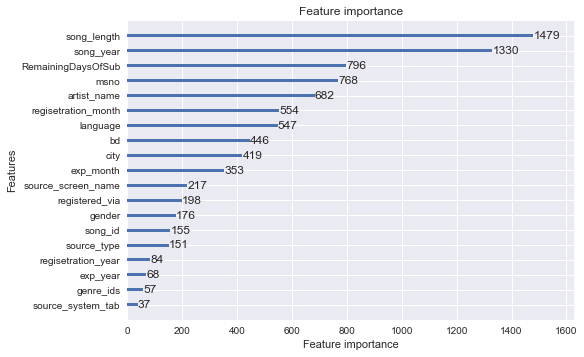

In [46]:
from lightgbm import plot_importance
plot_importance(model)
plt.show()